In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


**Read Inputs**

In [4]:
from zipfile import ZipFile
ZipFile("/kaggle/input/dogs-vs-cats/train.zip", "r").extractall()
ZipFile("/kaggle/input/dogs-vs-cats/test1.zip", "r").extractall()
train_dir = "./train/"
test_dir  = "./test1/"

**Get Labels**

In [6]:
train_names = os.listdir(train_dir)
categories = []
for filename in train_names:
    category = filename.split(".")[0]
    categories.append(category)
df = pd.DataFrame({
    "filename": train_names,
    "category": categories
})


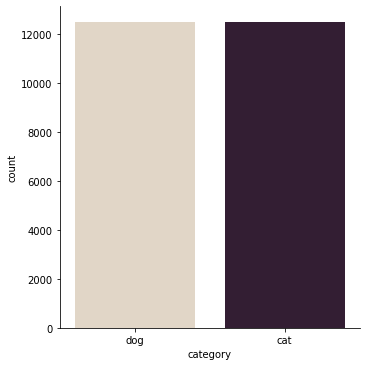

In [7]:
sns.catplot(x="category", kind="count", palette="ch:.25", data=df)

In [10]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
train_df.head(5)

,filename,category
23311,cat.11902.jpg,cat
23623,dog.4574.jpg,dog
1020,dog.7131.jpg,dog
12645,dog.71.jpg,dog
1533,cat.426.jpg,cat


In [12]:
train_df.reset_index(drop=True)

,filename,category
0,cat.11902.jpg,cat
1,dog.4574.jpg,dog
2,dog.7131.jpg,dog
3,dog.71.jpg,dog
4,cat.426.jpg,cat
...,...,...
19995,cat.2480.jpg,cat
19996,dog.2686.jpg,dog
19997,cat.1896.jpg,cat
19998,cat.407.jpg,cat


In [13]:
validation_df.reset_index(drop=True)

,filename,category
0,cat.8182.jpg,cat
1,dog.5072.jpg,dog
2,cat.7683.jpg,cat
3,cat.326.jpg,cat
4,dog.7372.jpg,dog
...,...,...
4995,cat.10415.jpg,cat
4996,cat.8578.jpg,cat
4997,cat.3941.jpg,cat
4998,cat.4295.jpg,cat


**Preprocessing**

In [14]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
training_set = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="filename",
    y_col="category",
    target_size=(120, 120),
    batch_size=64,
    class_mode='binary'
)


Found 20000 validated image filenames belonging to 2 classes.


In [15]:
from keras.preprocessing.image import ImageDataGenerator
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validation_set = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=train_dir,
    x_col="filename",
    y_col="category",
    target_size=(120, 120),
    batch_size=64,
    class_mode='binary'
)


Found 5000 validated image filenames belonging to 2 classes.


**Building the CNN**

In [20]:
from keras.layers import Flatten, Dense, Activation, Conv2D, BatchNormalization, LeakyReLU, Dropout,MaxPooling2D, Input
from keras.models import Model
input_layer = Input((120,120,3))
x = Conv2D(name='conv_layer1',filters = 32, kernel_size= 5, padding = 'same', strides = 1)(input_layer)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer2', filters = 64, kernel_size=3, padding = 'same', strides = 2)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer3', filters = 32, kernel_size=3, padding = 'same', strides = 1)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(244)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)
x = Dense(1)(x)
output_layer = Activation('sigmoid')(x)
model = Model(input_layer, output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 120, 120, 32)      2432      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 120, 120, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 120, 120, 32)      128       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 60, 60, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 60, 60, 64)        256 

In [18]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.08)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [52]:

model.fit( training_set
          , epochs=20
          , validation_data = validation_set)

Epoch 1/20
313/313 [==============================] - 123s 392ms/step - loss: 0.6545 - accuracy: 0.6147 - val_loss: 2.6629 - val_accuracy: 0.5174
Epoch 2/20
313/313 [==============================] - 123s 393ms/step - loss: 0.6299 - accuracy: 0.6492 - val_loss: 0.6237 - val_accuracy: 0.6632
Epoch 3/20
313/313 [==============================] - 122s 389ms/step - loss: 0.6181 - accuracy: 0.6600 - val_loss: 0.6349 - val_accuracy: 0.6500
Epoch 4/20
313/313 [==============================] - 122s 390ms/step - loss: 0.6081 - accuracy: 0.6722 - val_loss: 0.5942 - val_accuracy: 0.6854
Epoch 5/20
313/313 [==============================] - 121s 388ms/step - loss: 0.5981 - accuracy: 0.6840 - val_loss: 2.6186 - val_accuracy: 0.5020
Epoch 6/20
313/313 [==============================] - 122s 390ms/step - loss: 0.5918 - accuracy: 0.6874 - val_loss: 0.5892 - val_accuracy: 0.6898
Epoch 7/20
313/313 [==============================] - 123s 392ms/step - loss: 0.5886 - accuracy: 0.6898 - val_loss: 0.5945 -

In [60]:
from keras.layers import Flatten, Dense, Activation, Conv2D, BatchNormalization, LeakyReLU, Dropout,MaxPooling2D, Input
from keras.models import Model
input_layer = Input((120,120,3))
x = Conv2D(name='conv_layer1',filters = 32, kernel_size= 5, padding = 'same', strides = 1)(input_layer)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer2', filters = 64, kernel_size=3, padding = 'same', strides = 2)(x)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer3', filters = 32, kernel_size=3, padding = 'same', strides = 1)(x)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(244)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)
x = Dense(1)(x)
output_layer = Activation('sigmoid')(x)
model = Model(input_layer, output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 120, 120, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 60, 60, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0   

In [61]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit( training_set
          , epochs=20
          , validation_data = validation_set)

Epoch 1/20
313/313 [==============================] - 121s 386ms/step - loss: 0.9082 - accuracy: 0.5414 - val_loss: 0.9091 - val_accuracy: 0.5698
Epoch 2/20
313/313 [==============================] - 120s 385ms/step - loss: 0.6447 - accuracy: 0.6426 - val_loss: 1.7445 - val_accuracy: 0.5370
Epoch 3/20
313/313 [==============================] - 120s 383ms/step - loss: 0.6183 - accuracy: 0.6775 - val_loss: 0.7716 - val_accuracy: 0.6672
Epoch 4/20
313/313 [==============================] - 121s 386ms/step - loss: 0.5833 - accuracy: 0.7053 - val_loss: 0.6213 - val_accuracy: 0.7224
Epoch 5/20
313/313 [==============================] - 120s 383ms/step - loss: 0.5562 - accuracy: 0.7292 - val_loss: 0.5447 - val_accuracy: 0.7318
Epoch 6/20
313/313 [==============================] - 119s 381ms/step - loss: 0.5144 - accuracy: 0.7553 - val_loss: 0.5977 - val_accuracy: 0.7058
Epoch 7/20
313/313 [==============================] - 122s 389ms/step - loss: 0.5126 - accuracy: 0.7628 - val_loss: 0.4921 -

In [21]:
input_layer = Input((120,120,3))
x = Conv2D(name='conv_layer1',filters = 32, kernel_size= 5, padding = 'same', strides = 1)(input_layer)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer2', filters = 64, kernel_size=3, padding = 'same', strides = 2)(x)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer3', filters = 32, kernel_size=3, padding = 'same', strides = 2)(x)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(name = 'conv_layer4', filters = 64, kernel_size=3, padding = 'same', strides = 1)(x)
x = MaxPooling2D((2,2))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(100)(x)
x = Dropout(rate = 0.8)(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)
x = Dense(1)(x)
output_layer = Activation('sigmoid')(x)
model = Model(input_layer, output_layer)
model.summary()
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit( training_set
          , epochs=20
          , validation_data = validation_set)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 120, 120, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 60, 60, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0   

**Training**

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

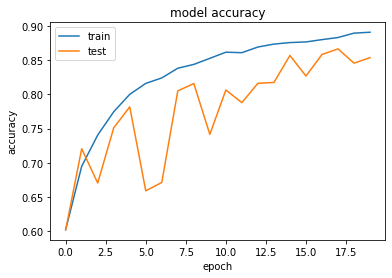

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

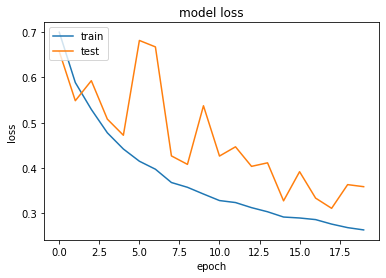

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Predict**

In [24]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [25]:
test_df

,filename
0,1656.jpg
1,1998.jpg
2,761.jpg
3,4569.jpg
4,10735.jpg
...,...
12495,8413.jpg
12496,8568.jpg
12497,7418.jpg
12498,9863.jpg


In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(120, 120),
    batch_size=32,
    shuffle=False
)


Found 12500 validated image filenames.


In [36]:
predict = model.predict(test_set, steps=np.ceil(nb_samples/32))

In [28]:
c = model.predict(test_set, steps=np.ceil(nb_samples/32))
print(c[0])

[0.0207875]


In [37]:
predict[0]

array([0.0207875], dtype=float32)

In [38]:
y = predict.reshape(-1)
print(y)

[2.0787502e-02 8.2896316e-01 4.1248205e-01 ... 4.6650305e-02 2.9941843e-04
 7.5891912e-01]


In [41]:
test_df['category'] = predict.reshape(-1)

In [42]:
test_df['category'] = test_df['category'].apply(lambda x: 0 if x < 0.5 else 1)

In [33]:
test_df.head()

,filename,category
0,1656.jpg,0
1,1998.jpg,1
2,761.jpg,0
3,4569.jpg,0
4,10735.jpg,0


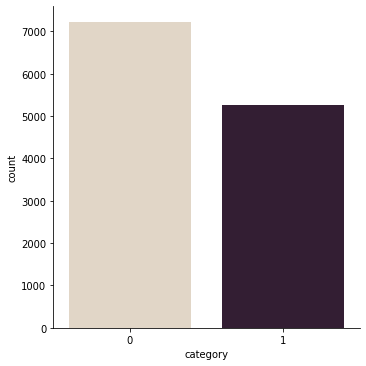

In [34]:
sns.catplot(x="category", kind="count", palette="ch:.25", data=test_df)

In [35]:
test_df.to_csv("predictions.csv")